# Exploring the SVHN Data

### Importing neccessary libraries

In [51]:

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy


### Define data augmentation

In [52]:
#Randomly transforms image and transforms to tensor

#No data augmentation
noTransform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])

#Translation/shift augmentation
shiftTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=0,translate=(0.08,0.08)),
    torchvision.transforms.ToTensor()
    ])

#Rotation augmentation
rotateTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.ToTensor()
    ])

#Random affine transformations (rotation, shift, scale, and shear)
randomAffineTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=(15), translate=(0.08, 0.08), scale=(0.9, 1), shear=15),
    torchvision.transforms.ToTensor()
    ])

#Random autocontrast
randomAutocontrastTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAutocontrast(),
    torchvision.transforms.ToTensor()
    ])


### Loading the test and training data

In [53]:
training = torchvision.datasets.SVHN(root="data/", split="train", transform=shiftTransform)
testing = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [54]:
n_epochs = 25
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(training, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(testing, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_26808/2269252473.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


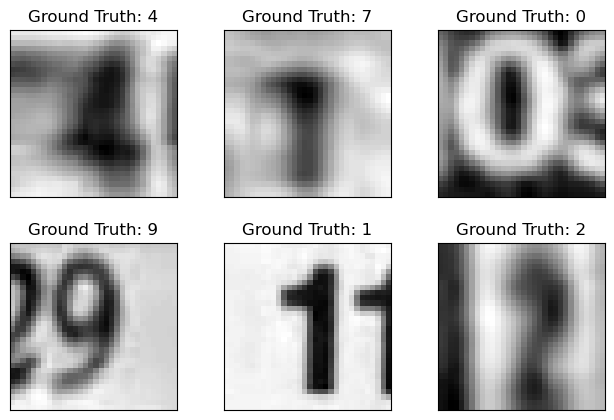

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [57]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [58]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [59]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [60]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [61]:
print(example_data.shape)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([1000, 3, 32, 32])


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_26808/235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3034, Accuracy: 1977/26032 (8%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.303460
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.309236
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.297785
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.296829
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.293596
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.276020
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.275065
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.287698
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.274675
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.274177
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.279699
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.264748
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.267506
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.229588
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.269937
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.260477
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.251718
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.218318
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.175005
Train Epoch: 1 [12160/73

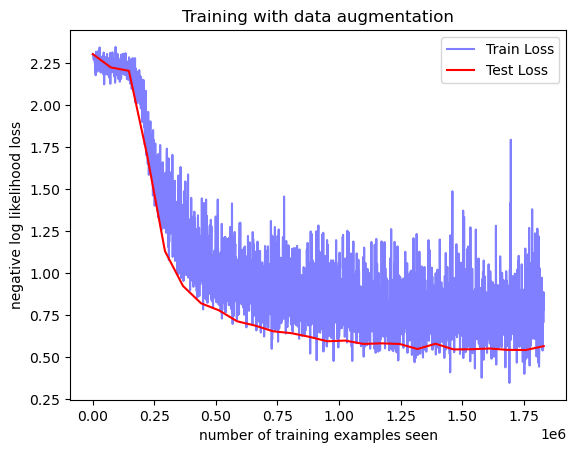

In [80]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', alpha=0.5)
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('Training with data augmentation')
fig
plt.show()

In [63]:
with torch.no_grad():
  output = network(example_data)

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_26808/235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [64]:
train_losses_aug = copy.deepcopy(train_losses)
train_counter_aug = copy.deepcopy(train_counter)
test_losses_aug = copy.deepcopy(test_losses)
test_counter_aug = copy.deepcopy(test_counter)

In [65]:
training = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
testing = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

n_epochs = 25
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(training, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(testing, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_26808/235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3034, Accuracy: 1977/26032 (8%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.303498
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.305519
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.295510
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.296159
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.288930
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.284162
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.270587
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.285296
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.270787
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.277523
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.294074
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.270427
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.266434
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.249280
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.267480
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.272903
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.268380
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.218011
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.177498
Train Epoch: 1 [12160/73

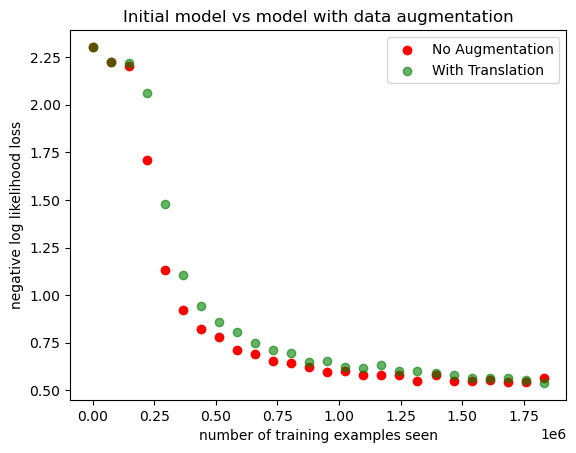

In [79]:
fig = plt.figure()
#plt.plot(train_counter, train_losses, color='blue', alpha=0.5)
plt.scatter(test_counter, test_losses, color='red')
plt.scatter(test_counter_aug, test_losses_aug, color='green', alpha=0.6)
plt.legend(['No Augmentation', 'With Translation'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('Initial model vs model with data augmentation')
fig
plt.show()

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_26808/2502561851.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


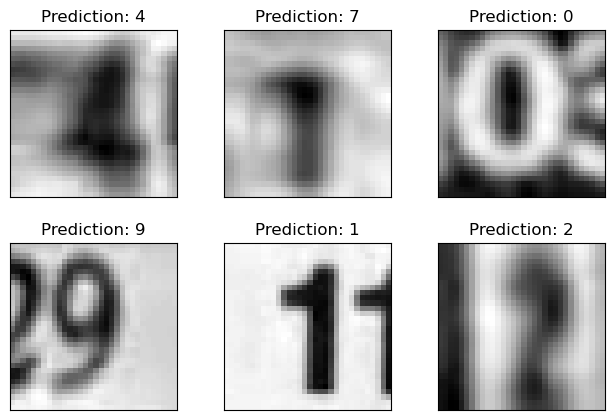

In [67]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()